<a href="https://colab.research.google.com/github/GalindoD/Backtesting-v1/blob/main/Backtester_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install backtrader yfinance matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 4.6 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import plotly.express as px
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4019    0  4019    0     0   8078      0 --:--:-- --:--:-- --:--:--  8086
100  517k  100  517k    0     0   327k      0  0:00:01  0:00:01 --:--:--  492k
--2025-04-16 23:31:56--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

#Function for Data gathering

In [3]:
def gatherdata(ticker):
  data = yf.download(
      tickers = ticker,
      period="max",
      interval="5d",
      ignore_tz=True,
      auto_adjust=True)
  return data

def createdf(data, fastma, slowma, fastmacd, slowmacd, signal):
  data_df = data.copy()
  data_df.columns = ["close", "high", "low", "open", "volume"]
  data_df.drop(columns=["volume", "high", "low", "open"], inplace=True)

  data_df["R"] = data_df.close.pct_change().fillna(0)

  #Calculating values of Indicators
  data_df["slow_ma"] = talib.SMA(data_df.close, slowma)
  data_df["fast_ma"] = talib.SMA(data_df.close, fastma)
  data_df["macd"], data_df["signal"], data_df["histogram"] = talib.MACD(data_df.close, fastperiod=fastmacd, slowperiod=slowmacd, signalperiod=signal)

  #Delete First NA rows, resultring form lack of previous data
  data_df.dropna(inplace=True)
  return data_df

#Function for Computing Buy Signals

In [4]:

def signalcompute(data_df):
  data_df = data_df.assign(
      macdbuy = lambda x: np.where( x.macd > x.signal ,1,0)
      )
  data_df = data_df.assign(
      fastmabuy = lambda x: np.where( x.close > x.fast_ma ,1,0)
      )
  data_df = data_df.assign(
      slowmabuy = lambda x: np.where( x.close > x.slow_ma ,1,0)
      )
  return data_df

In [5]:
def compute_strategy(data_df, strategy):
  data_df["buy"] = 0
  match strategy:
    case 1:
      #Strategy 1: MACD and MA, buy both signals 1 and sell both signals 0
      for i in range(len(data_df)):
        if ( data_df["macdbuy"].iloc[i] == 1 and data_df["fastmabuy"].iloc[i]  == 1):
          data_df["buy"].iloc[i] = 1
        elif ((data_df["macdbuy"].iloc[i] == 1 or data_df["fastmabuy"].iloc[i] == 1) and data_df["buy"].iloc[i-1] == 1):
          data_df["buy"].iloc[i] = 1
        else:
          data_df["buy"].iloc[i] = 0
    case 2:
      #Strategy 2: MACD and MA, buy both signals 1 and sell when either signal is 0
      for i in range(len(data_df)):
        if ( data_df["macdbuy"].iloc[i] == 1 and data_df["fastmabuy"].iloc[i] == 1):
            data_df["buy"].iloc[i] = 1
        else:
            data_df["buy"].iloc[i] = 0
    case 3:
      #Strategy 3: Only MACD
      for i in range(len(data_df)):
        if ( data_df["macdbuy"].iloc[i] == 1 ):
            data_df["buy"].iloc[i] = 1
        else:
            data_df["buy"].iloc[i] = 0
    case 4:
      #Strategy 4: MACD and SlowMA and FastMA
      for i in range(len(data_df)):
        if ( data_df["macdbuy"].iloc[i] == 1 and data_df["fastmabuy"].iloc[i] == 1 and data_df["slowmabuy"].iloc[i]):
            data_df["buy"].iloc[i] = 1
        else:
            data_df["buy"].iloc[i] = 0

  #Shift
  data_df["buy"] = data_df["buy"].shift(1, fill_value=0)

  #Buying according to strategy
  data_df["R_strategy"] = data_df.R * data_df.buy

  #Assuming 5% return on liquid
  data_df['R_strategy'] = data_df['R_strategy'].replace([0], 0.0001369)

  #Calculating total Return
  returns = 100 * (1+data_df[["R","R_strategy"]]).prod()-1

  #Adding transaction costs to Strategy
  for i in range(len(data_df["buy"])):
      try:
        if data_df["buy"].iloc[i] != data_df["buy"].iloc[i+1]:
          data_df["R_strategy"].iloc[i+1] = data_df["R_strategy"].iloc[i+1] - trsncost
        else:
          continue
      except:
        print("End")


  return data_df



In [43]:
#Main Cell


#Variables
ticker = "BTC-USD"
#ticker = "QQQ"
#ticker = "TQQQ"

trsncost = 0.002

#Strategy 1: MACD and MA, buy both signals 1 and sell both signals 0. 0.658x
#Strategy 2: MACD and MA, buy both signals 1 and sell when either signal is 0. 0.8033x
#Strategy 3: Only MACD. 0.8409x
#Strategy 4: MACD and SlowMA and FastMA. 0.9272x w 40SlowMA
strategy = 4

slowma = 40
fastma = 10

#---Rule1
#fastmacd = 8
#slowmacd = 17
#signal = 9


fastmacd = 8
slowmacd = 17
signal = 9

#Gather the data
data = gatherdata(ticker)

#Create dataframe
data_df = createdf(data, fastma, slowma, fastmacd, slowmacd, signal)

#Compute the signal
data_df = signalcompute(data_df)

#Choose and compute strategy
data_df = compute_strategy(data_df, strategy)




Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:31: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-5-05e3dd9a2e08>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice

End


<ipython-input-5-05e3dd9a2e08>:51: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-5-05e3dd9a2e08>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [44]:
#Total Return with transaction costs
returns = 100 * (1+data_df[["R","R_strategy"]]).prod()-1
print("With transaction cost:")
print("Return of Holding: ", returns.iloc[0])
print("Return of Strategy: ", returns.iloc[1])
print("The return of this strategy is ",round((returns.iloc[1]/returns.iloc[0]).item(), 4), "x of holding. Ticker: ", ticker)

With transaction cost:
Return of Holding:  33850.75280653432
Return of Strategy:  31403.879846336302
The return of this strategy is  0.9277 x of holding. Ticker:  BTC-USD


In [45]:
px.line(100 * (1 + data_df[["R","R_strategy"]]).cumprod(), title="Total Return")

In [48]:
#Loop Cell


#Variables

ticker = "BTC-USD"
#ticker = "QQQ"
#ticker = "TQQQ"

trsncost = 0.002
strategy = 4
slowma = 40
fastma = 10

#Gather the data
data = gatherdata(ticker)

slowmacd = 17
signal = 9

returns_df = pd.DataFrame({'Values': ['MACD','Hold', 'Strategy', 'VS']})


for fastmacd in range(7, 15):
  #Create dataframe
  data_df = createdf(data, fastma, slowma, fastmacd, slowmacd, signal)

  #Compute the signal
  data_df = signalcompute(data_df)

  #Choose and compute strategy
  data_df = compute_strategy(data_df, strategy)

  #Total Return with transaction costs
  returns = 100 * (1+data_df[["R","R_strategy"]]).prod()-1

  column_name = "fastmacd_" + str(fastmacd)
  for row in range(4):
    list1 = [fastmacd, returns.iloc[0], returns.iloc[1], round((returns.iloc[1]/returns.iloc[0]).item(), 4)]
    returns_df.loc[row, column_name] = list1[row]

Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:33: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:31: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:33: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:31: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:33: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:33: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


Streaming output truncated to the last 5000 lines.
<ipython-input-5-05e3dd9a2e08>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:31: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating th

End


<ipython-input-5-05e3dd9a2e08>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:33: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentat

End


<ipython-input-5-05e3dd9a2e08>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-05e3dd9a2e08>:33: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentat

In [49]:
returns_df

,Values,fastmacd_7,fastmacd_8,fastmacd_9,fastmacd_10,fastmacd_11,fastmacd_12,fastmacd_13,fastmacd_14
0,MACD,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000
1,Hold,33862.811113,33862.811113,33862.811113,33862.811113,33862.811113,33862.811113,33862.811113,33862.811113
2,Strategy,19741.165910,31403.879846,32773.440472,28460.709201,24662.154854,22662.573286,22662.573286,24111.938214
3,VS,0.583000,0.927400,0.967800,0.840500,0.728300,0.669200,0.669200,0.712000


#Plot last 200 values

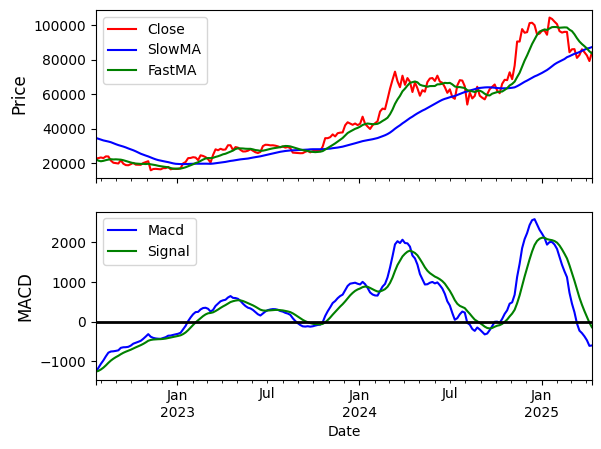

In [50]:
last_200 = data_df.tail(200)


# Prepare plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

#Plot SMA and Price
ax1.set_ylabel('Price', size=12)
last_200.close.plot(ax=ax1, color='r', label='Close')
last_200.slow_ma.plot(ax=ax1, color='b', label='SlowMA')
last_200.fast_ma.plot(ax=ax1, color='g', label='FastMA')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

# Plot MACD
ax2.set_ylabel('MACD', size=12)
last_200.macd.plot(ax=ax2, color='b', label='Macd')
last_200.signal.plot(ax=ax2, color='g', label='Signal')
ax2.axhline(0, lw=2, color='0')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)


plt.show()

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 2 rows, 1 column, shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1,
                    subplot_titles=("Price and Moving Averages", "MACD"))

# Row 1: Price and Moving Averages
fig.add_trace(go.Scatter(x=last_200.index, y=last_200['close'],
                         mode='lines', name='Close'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=last_200.index, y=last_200['slow_ma'],
                         mode='lines', name='SlowMA'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=last_200.index, y=last_200['fast_ma'],
                         mode='lines', name='FastMA'),
              row=1, col=1)

# Row 2: MACD and Signal Line
fig.add_trace(go.Scatter(x=last_200.index, y=last_200['macd'],
                         mode='lines', name='MACD'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=last_200.index, y=last_200['signal'],
                         mode='lines', name='Signal'),
              row=2, col=1)

# Horizontal line at y=0 on MACD plot
fig.add_shape(type="line",
              x0=last_200.index.min(), x1=last_200.index.max(),
              y0=0, y1=0,
              line=dict(color="gray", width=2),
              row=2, col=1)

# Layout and labels
fig.update_layout(height=600, width=900, showlegend=True,
                  title_text="Price, Moving Averages, and MACD")

fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="MACD", row=2, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)

fig.show()

#Test code

In [ ]:
test_df = data_df.tail(50)

In [ ]:
test_df = test_df.drop(columns=['slow_ma','fast_ma', 'macd', 'signal', 'histogram'])

In [ ]:
test_df.drop(test_df.index[:5], inplace=True)

In [ ]:
test_df.drop(index=test_df.index[-10:], axis=0, inplace=True)

In [ ]:
test_df

In [ ]:
test2_df = test_df.copy()

In [ ]:
test2_df["buy"] = 0

In [ ]:
test2_df = test2_df.drop(columns=['close','R'])

In [ ]:
test2_df

In [ ]:
for i in range(len(test2_df)):
  if ( test2_df["macdbuy"].iloc[i] == 1 and test2_df["mabuy"].iloc[i] ) == 1:
#      print("Double 1")
#      print(test2_df["buy"].iloc[i].index())
      test2_df["buy"].iloc[i] = 1
#      test2_df.loc[i, "buy"] = 1
  elif ((test2_df["macdbuy"].iloc[i] == 1 or test2_df["mabuy"].iloc[i] == 1) and test2_df["buy"].iloc[i-1] == 1):
#      print("Single 1")
      test2_df["buy"].iloc[i] = 1
#      test2_df.loc[i, "buy"] = 1
  else:
#      print("NO BUY")
      test2_df["buy"].iloc[i] = 0
#      test2_df.loc[i, "buy"] = 0

In [ ]:
test2_df

In [ ]:
for i in range(len(test2_df["buy"])):
    try:
      if test2_df["buy"].iloc[i] != test2_df["buy"].iloc[i+1]:
        print("Different")
        test2_df["R_strategy"].iloc[i+1] = test2_df["R_strategy"].iloc[i+1] - trsncost
      else:
        continue
    except:
      print("End")

In [ ]:
test2_df